In [ ]:
# Imports

In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [35]:
# Create the train, test and validation sets and loaders

In [25]:
device = torch.device("cpu")

data_path = "C:/Users/markn/PycharmProjects/ML-Sudoku-Solver/editted_dataset"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

X = datasets.ImageFolder(root=data_path, transform=transform)

train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = random_split(X, [train_size, test_size])

train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size
X_train, X_val = random_split(X_train, [train_size, val_size])

train_loader = DataLoader(X_train, batch_size=64, shuffle=True)
val_loader = DataLoader(X_val, batch_size=64, shuffle=False)
test_loader = DataLoader(X_test, batch_size=64, shuffle=False)

In [36]:
# Create the CNN

In [27]:
class DigitClassifierCNN(nn.Module):
    def __init__(self):
        super(DigitClassifierCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return x

In [37]:
# Instantiate the model and loss function

In [32]:
model = DigitClassifierCNN()

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [38]:
# Train, test and validate the model

Epoch 1/10, Train Loss: 1.4417, Val Loss: 0.3236, Val Acc: 94.16%
Epoch 2/10, Train Loss: 0.5010, Val Loss: 0.1940, Val Acc: 94.90%
Epoch 3/10, Train Loss: 0.3556, Val Loss: 0.1537, Val Acc: 95.69%
Epoch 4/10, Train Loss: 0.2957, Val Loss: 0.1289, Val Acc: 96.00%
Epoch 5/10, Train Loss: 0.2663, Val Loss: 0.1207, Val Acc: 96.49%
Epoch 6/10, Train Loss: 0.2347, Val Loss: 0.1084, Val Acc: 96.80%
Epoch 7/10, Train Loss: 0.2170, Val Loss: 0.0985, Val Acc: 97.11%
Epoch 8/10, Train Loss: 0.2077, Val Loss: 0.0920, Val Acc: 97.23%
Epoch 9/10, Train Loss: 0.1872, Val Loss: 0.0874, Val Acc: 97.42%
Epoch 10/10, Train Loss: 0.1772, Val Loss: 0.0804, Val Acc: 97.17%


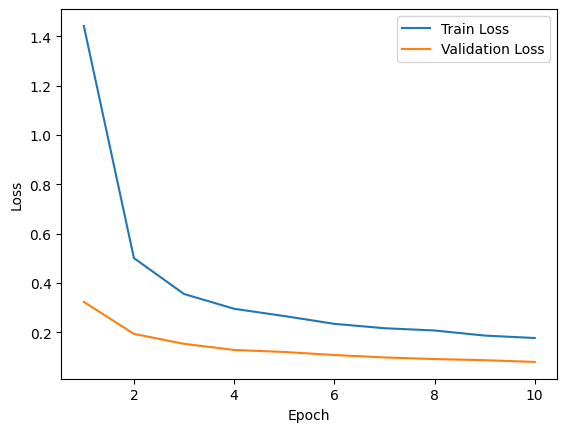

Model saved!
Test Loss: 0.0627, Test Accuracy: 97.98%


In [34]:
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Plot loss curves
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), "digit_classifier.pt")
print("Model saved!")

# Testing phase
model.eval()
correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")